# *Librerie usate e varie installazioni*

In [1]:
!git clone https://github.com/jminuscula/dixit-online dixit_online

Cloning into 'dixit_online'...
remote: Enumerating objects: 1376, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 1376 (delta 42), reused 31 (delta 18), pack-reused 1310
Receiving objects: 100% (1376/1376), 12.33 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (738/738), done.


In [2]:
pip install torchvision transformers openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
import os
from transformers import BlipProcessor, BlipForConditionalGeneration,CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import random

# **IA**

## Descrizione della carta in input

In [97]:
words_to_avoid=['about','a','at','of','an','it','with','but','by','for','from','in','inside','outside','into','like','near','off','on','onto','over','to','under','within','without','up','around','painting','illustration']

In [104]:
def generate_concise_description(model, processor, image, max_length=100):
    inputs = processor(images=image, return_tensors="pt")
    out = model.generate(**inputs, max_length=max_length, num_beams=3, early_stopping=False)
    description = processor.decode(out[0], skip_special_tokens=True)
    return description

In [120]:
def Narrator_turn_for_AI(image):
  c=generate_concise_description(blip_model, blip_processor, image).split()

  i=0
  while i<len(c):
    if c[i] in words_to_avoid:
      c.pop(i)
    else:i+=1
  return c

## Cerca la carta migliore per la descrizione ricevuta

In [123]:
def find_best_matching_image(image_paths, target_description, blip_model, blip_processor, clip_model, clip_processor):

    images = [(mpimg.imread(image_path),i) for i,image_path in enumerate(image_paths)]

    target_inputs = clip_processor(text=target_description, return_tensors="pt", padding=True)

    target_features = clip_model.get_text_features(**target_inputs)

    best_image = None
    best_score = (-1,-1)

    for image,i in images:
        description = generate_concise_description(blip_model, blip_processor, image)
        image_inputs = clip_processor(text=description, return_tensors="pt", padding=True)
        image_features = clip_model.get_text_features(**image_inputs)

        score = (cosine_similarity(target_features.detach().numpy(), image_features.detach().numpy()),i)

        if score[0] > best_score[0]:
            best_score = score
            best_image = image

    return image_paths[best_score[1]]

# **Il Gioco**

### **Creo il mazzo**

#### refill del mazzo di carte

In [125]:
def refill():
  path_of_images=os.listdir('/content/dixit_online/cards')
  allcards=[]
  for i in path_of_images:
    allcards.append(f'/content/dixit_online/cards/{i}')
  return allcards

def again(old,new):
  new=old
  return new,[]

#### Controllo se l'input dell'utente è un numero consentito

In [ ]:
def check_int(num,l,r,ok=False):
  while not ok:
    try: int(num)
    except ValueError:
      print(f'must be a number between {l} and {r}')
      num=input()

    else:
      num=int(num)

      if num>r:
        print(f'max is {r} included')
        num=input()
      elif num<l:
        print(f'min is {l} included')
        num=input()
      else:return num


## **I Giocatori**

### Classe per il giocatore e l'IA

In [5]:
discarded,turn=[],[]
end=False
tot_points=30

class Persona():

  # ogni giocatore ha punti,deck e nome, inoltre al deck vengono immediatamente aggiunte 6 carte (7 se ci sono solo 2 giocatori ed IA)
  def __init__(self,name):
    self.points=0
    self.deck=[]
    self.Name=name
    for _ in range(c):
      self.Add_card(allcards,discarded)

  # al Narratore viene 1. mostrato il deck, 2. sceglie l'indice della carta selta 3. la carta viene rimossa dal suo deck e aggiunta alla pila degli scarti 4. sceglie una descrizione per la carta giocata
  def Narrator(self):

    print(f'{self.Name}, you are the Narrator! \nchoose the card You want to play')
    self.show_deck()  #1
    print('insert number here:')
    n=check_int(input(),0,c+1)-1 #2

    card=self.deck.pop(n) #3
    discarded.append(card) #3

    print('Give a descritpion for the card you played')
    description=input() #4


    return card,description

  # al Giocatore viene 1. mostrato il deck, 2. sceglie l'indice della carta selta 3. la carta viene rimossa dal suo deck e aggiunta alla pila degli scarti
  def Player(self,description):
    print(f'{self.Name}, you are the player! \nThis is the description you are given:\n{description} \nchoose a card')
    self.show_deck() #1
    print(f'insert the number of the card:')
    j=check_int(input(),1,c+1) #2
    card=self.deck.pop(j-1) #3
    discarded.append(card) #3
    return card

  # Funzione che serve ad aggiungere una carta al deck del Player controllando che non abbia più carte di quelle consentite in base al numero di giocatori
  def Add_card(self,allcards,discarded):

    if len(self.deck)<c:
      r=random.randint(0,len(allcards)-1)
      self.deck.append(allcards.pop(r))

  # funzione che controlla se il Player non ha più punti del necessario per la vittoria, in tal caso il gioco si conclude
  def check(self):
    return True if self.points>=tot_points else False

  # funzione per mostrare il deck del Player
  def show_deck(self):
    for a,i in enumerate(self.deck):
      img = mpimg.imread(i)
      imgplot = plt.imshow(img)
      plt.axis('off')
      plt.title(f'card N.{a+1}')
      plt.show()
    return

  # print()
  def __repr__(self):
    print(f'Player:{self.Name} \npoints:{self.points} \ncurrent deck: {len(self.deck)}\n')
    self.show_deck()
    return ''


class AI(Persona):


  def Narrator(self):

    card=self.deck.pop(random.randint(0,len(self.deck)-1))
    discarded.append(card)
    print("the IA is the Narrator! give it some time...")
    description=Narrator_turn_for_AI(card)
    self.Add_card(allcards,discarded)
    return card,description

  def Player(self,description):
    print("the IA is thinking...")
    card=find_best_matching_image(self.deck, description, blip_model, blip_processor, clip_model, clip_processor)
    print('Done')
    self.deck.remove(card)
    discarded.append(card)
    self.Add_card(allcards,discarded)
    return card


100


### Per ogni giocatore creo una classe + la IA

In [ ]:
allcards=refill()# allcards è un array con i path di ogni carta
e={}
ok=False
n=None
print('How many players? (min 2 max 5)')

n=check_int(input(),2,5)


c=6 #ogni giocatore avrà 7 carte o 6 dipendentemente se saranno rispettivamente 2+IA o di più fino a 5+IA
if n==2:c+=1

# creazione dei Players
i=0
while i<n:
  print("What's your name?\n")
  x=input()
  if x=='lulu':break
  if x not in e and x:
    e[x]=Persona(x)
    i+=1
  else:print('name not valid, please choose another')


e['IA']=AI('IA')

turn=[x for x in e.keys()]

Narr=turn.pop(random.randint(0,len(turn)-1)) #scegli un Narratore a caso



100
How many players? (min 2 max 5)
c
must be a number between 2 and 5
4
What's your name?

K
What's your name?

S
What's your name?

E
What's your name?

R


## **Turni**

S, you are the Narrator! 
 choose the card You want to play


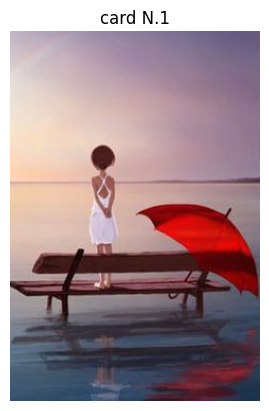

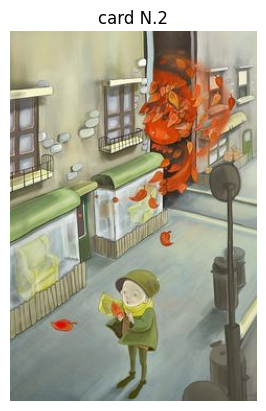

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
#turn nome
#e nome -> classe

card=''
description=''
end=False
counter=0
while not end:
  played_cards={}
  voting={}
  Narrator_card,description=e[Narr].Narrator() # il Narratore sceglie carta e descrizione

  if not allcards: #refill del deck in caso si sia svuotato, la pila degli scarti diventa il deck e poi si azzera
      allcards,discarded=again(discarded,allcards)

  played_cards[Narrator_card]='Narrator'
  played_cards_index=[Narrator_card]

  #played card -> player
  for p in turn:
    card=e[p].Player(description) # il ogni giocatore sceglie una carta in base alla descrizione fornita
    played_cards_index.append(card)
    played_cards[card]=e[p].Name
    if not allcards:
      allcards,discarded=again(discarded,allcards)




  for a,i in enumerate(played_cards.keys()): #print ogni carta giocata
      img = mpimg.imread(i)
      imgplot = plt.imshow(img)
      plt.axis('off')
      plt.title(f'card N.{a+1}')
      plt.show()


  for p in turn: #ogni Giocatore vota una carta, non può votare la sua carta, e i voti vengono salvati in nu dict con  indice carta votata: classi di chi ha votato quella carta
    print(f'{e[p].Name} Vote a card, the description is: {description}')
    not_vote_himself=True
    while not_vote_himself:
      x=check_int(input(),1,len(played_cards.keys()))-1
      if played_cards[played_cards_index[x]] == e[p].Name:print(f"{e[p].Name} you can't vote your own card, choose another one")
      else:
        if x in voting :voting[x].append(p)
        else:voting[x]=[p]
        not_vote_himself=False



  points_to_be_assigned=[]

  for v in voting: # ogni carta votata assegna punti ai Player o al Narratore in base alle regole del gioco

    if len(voting[v])==n:
      if played_cards[played_cards_index[v]]!='Narrator':
        voting[v].points+=n
        print(f"Everyone voted for {voting[v].Name}'s card, It gets {str(n)} points!")
        break
      print(f"Everyone voted for the Narrator's card!")
      for p in turn: points_to_be_assigned.append((e[o].Name,2))
      break

    elif played_cards[played_cards_index[v]]!='Narrator':
      points_to_be_assigned.append((played_cards[played_cards_index[v]],len(voting[v])))
    else:
      points_to_be_assigned.append(('Narrator',3))
      for x in voting[v]:
        points_to_be_assigned.append((e[x],3))



  # svelo carta del Narratore e assegno punti a tutti
  print(f'The Narrator card was:')
  img = mpimg.imread(Narrator_card)
  imgplot = plt.imshow(img)
  plt.axis('off')
  plt.title(f"{e[Narr].Name}'s card")
  plt.show()
  for p in points_to_be_assigned:
    if p[0]=='Narrator':temporary=e[Narr].Name
    else:temporary=p[0]
    print(f"{temporary} got {p[1]} points")
    e[temporary].points+=p[1]



  input()
  Winner=[]
  print("recap")
  for x in turn+[Narr]:
      end=e[x].check()
      if end:
        Winner=x

      print(f"{e[x].Name} has {e[x].points} points")


  # nuovo narratore
  turn.append(Narr)
  Narr=turn.pop(0)


  print("ready for next turn?")
  x=input()
  if x in ['no','No','nO','NO','Nope']:
    print('ok bye')
    break


  if end:break
  counter+=1
  if counter==2:break


print(f"Game is over, the winner is {e[x]} with {e[x].points}")
